# Clustering with PCA

# Exercise: PCA and Clustering on High-Dimensional Data

In this exercise, we want to analyze the ability of PCA in clustering data by projecting very high-dimensional datapoints to 2 or 3 dimensions. In particular, consider the same MNIST dataset used in the previous exercise. You are asked to:

1. Load and pre-process the dataset as did in the previous exercise, to get the matrix $X$ with shape $(784, 42000)$, and the associated vector $Y$.

2. Choose a number of digits (for example, 0, 6, and 9) and extract from $X$ and $Y$ the sub-dataset containing only the considered digits, as did in the previous exercise.

3. Set $N_{train}<N$ and randomly sample a training set with $N_{train}$ datapoints from $X$ and $Y$. Call them $X_{\text{train}}$ and $Y_{\text{train}}$. Everything else is the test set. Call them $X_{\text{test}}$ and $Y_{\text{test}}$, correspondingly. This has to be done after filtering out the selected digits from $X$ and $Y$.

4. Implement the algorithms computing the PCA of $X_{\text{train}}$ with a fixed value of $k$. Visualize the results (for $k=2$) and the position of the centroid of each cluster. The clusters are identified by projecting $X_{\text{train}}$ via PCA to its low-dimension version $Z_{\text{train}}$, and then splitting it into sets (say, $Z_1, Z_2, Z_3$) based on the digit that was represented in that position before the PCA projection. Each set $Z_1, Z_2, Z_3$ represents a cluster, of which we can easily compute the centroid.

5. Compute, for each cluster, the average distance from its centroid. Which property of PCA projection does this quantity measure?

6. By keeping the same projection matrix $P$ from the train set, project the test set $X_{\text{test}}$ on the low-dimensional space.

7. Consider the clusters in $X_{\text{test}}$ by considering the information on $Y_{\text{test}}$, similarly to what we did on the previous point. Consider the centroids computed from the training set. For each cluster in the test set, compute the average distance to the corresponding centroid (from the train set). Comment on the results.

8. Define a classification algorithm in this way: given a new observation $x$, compute the distance between $x$ and each cluster centroid computed on the training set. Assign $x$ to the class corresponding to the closest centroid. Compute the misclassification rate of this algorithm on the test set.

9. Repeat this experiment for different values of $k$ and different digits. What do you observe?

10. Compare this classification algorithm with the one defined in the previous exercise. Which performs better?

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

1. Load and pre-process the dataset as did in the previous exercise, to get the matrix $X$ with shape $(784, 42000)$, and the associated vector $Y$.

In [16]:
# read images dataset
data = pd.read_csv('./data/train.csv')

# transform data into numpy array
data = np.array(data)

# get all the rows (images) and all the column (pixels) except for the first one (which corresponds to the labels)
X = data[:, 1:]
# transpose the matrix in order to have the images on the columns and the pixels on the rows
X = X.T

# labels
Y = data[:, 0] 

print(f"The shape of matrix X is {X.shape}: in particular, {X.shape[0]} pixels for each image and a total of {X.shape[1]} images,")
print(f"while the shape of matrix Y is: {Y.shape}, corresponding to the number of lables (one for each image)")

The shape of matrix X is (784, 42000): in particular, 784 pixels for each image and a total of 42000 images,
while the shape of matrix Y is: (42000,), corresponding to the number of lables (one for each image)


2. Choose a number of digits (for example, 0, 6, and 9) and extract from $X$ and $Y$ the sub-dataset containing only the considered digits, as did in the previous exercise.


In [17]:
def filtering_out(X, Y, n1, n2, n3):
    # create the boolean mask
    img_filtered = (Y == n1) | (Y == n2) | (Y == n3)
    
    # from X (all images) i filter only the one corresponding
    # to the choosen numbers
    X_filtered = X[:, img_filtered]
    # from Y i filter only the labels corresponding to the 
    # number 0, 6 and 9
    Y_filtered = Y[img_filtered]
    
    return (X_filtered, Y_filtered)

X_filtered, Y_filtered = filtering_out(X, Y, 0, 6, 9)
print(f"The shape of matrix X is {X_filtered.shape}, while the shape of matrix Y is: {Y_filtered.shape}")

The shape of matrix X is (784, 12457), while the shape of matrix Y is: (12457,)


We can see that the filtering was successful because the shapes of `X_filtered` and `Y_filtered` have been reduced in the number of columns (i.e., the number of images).

3. Set $N_{train}<N$ and randomly sample a training set with $N_{train}$ datapoints from $X$ and $Y$. Call them $X_{\text{train}}$ and $Y_{\text{train}}$. Everything else is the test set. Call them $X_{\text{test}}$ and $Y_{\text{test}}$, correspondingly. This has to be done after filtering out the selected digits from $X$ and $Y$.


In [18]:
def sampling(X_filtered, Y_filtered):
    # N = number of images = Y_filtered.shape[0]
    N = Y_filtered.shape[0]
    # N_train = 80% * N
    N_train = int(0.8 * N)
    
    # arrays of numbers
    idx = np.arange(N)
    # shuffle datas in order to have random training and test data
    np.random.shuffle(idx)
    
    # indexes 
    train_idx = idx[:N_train]
    test_idx = idx[N_train:]
    
    # X matrix
    X_train = X_filtered[:, train_idx]

    X_test = X_filtered[:, test_idx]
    
    # Y matrix
    Y_train = Y_filtered[train_idx]
    Y_test = Y_filtered[test_idx]
    
    return (X_train, Y_train), (X_test, Y_test)

(X_train, Y_train), (X_test, Y_test) = sampling(X_filtered, Y_filtered)
print(X_train.shape, X_test.shape)

(784, 9965) (784, 2492)


4. Implement the algorithms computing the PCA of $X_{\text{train}}$ with a fixed value of $k$. Visualize the results (for $k=2$) and the position of the centroid of each cluster. The clusters are identified by projecting $X_{\text{train}}$ via PCA to its low-dimension version $Z_{\text{train}}$, and then splitting it into sets (say, $Z_1, Z_2, Z_3$) based on the digit that was represented in that position before the PCA projection. Each set $Z_1, Z_2, Z_3$ represents a cluster, of which we can easily compute the centroid.

In [19]:
def PCA_algorithm(X, X_train, k=2):
    # Compute centroid
    cX = np.mean(X, axis=1)

    # Make it a column vector
    cX = np.reshape(cX, (X.shape[0], 1))

    # Center the data
    Xc = X - cX

    # Compute SVD decomposition
    U, s, VT = np.linalg.svd(Xc, full_matrices=False)

    # Given k, compute reduced SVD
    Uk = U[:, :k]

    # Define projection matrix
    P = Uk.T

    # Project X_train -> Z_train
    Z_train = P @ X_train

    return Z_train

Z_train = PCA_algorithm(X, X_train, k = 2)
print(Z_train.shape)

(2, 9965)


### Clusters visualization

In [20]:
def cluster_centroid(Z_train, Y_train):
    # set label = [0, 6, 9] without repetition
    labels = np.unique(Y_train)

    # clusters is dictionary in the form -> label: [point1, point2, ...]
    # and each point, in dimension k=2, has 2 coordinates (it's a matrix 
    # where each column correspond to the point and the first row corrisponds to coordinate x
    # while second row to coordinate y)
    clusters = {}
    for label in labels:
        clusters[label] = []
        # each column on Z_train represents a point in dimension k = 2
        for i in range(Z_train.shape[1]):
            # for each point in Z_train, if it corrisponds to the index == label
            # i save that column (point) in the cluster related to that label
            if Y_train[i] == label:
                clusters[label].append(Z_train[:, i])
        # then i transpose to have the shape (k, n_points)
        clusters[label] = np.array(clusters[label]).T 

    # Compute the centroid for each cluster (identified by its label)
    # in the form of a dictionary: centroid1: [coordinate_x, coordinate_y]
    centroids = {}
    for label, points in clusters.items():
    # Compute the mean over the columns
        centroid = points.mean(axis=1)  
        centroids[label] = centroid

    return clusters, centroids

clusters, centroids = cluster_centroid(Z_train, Y_train)

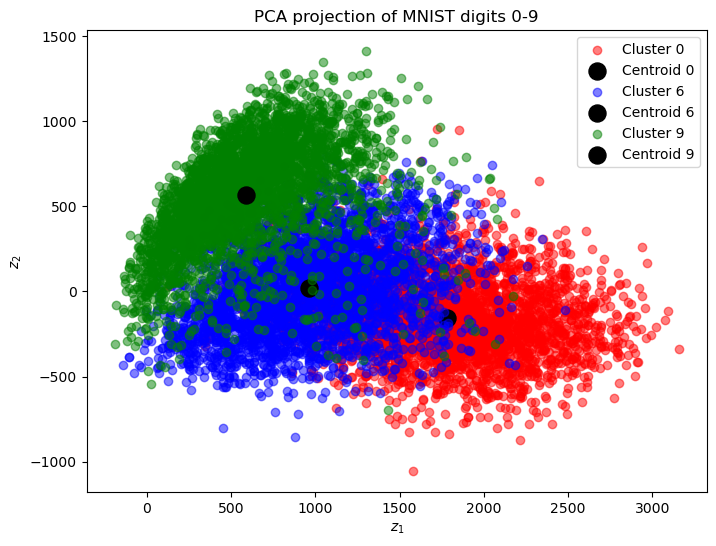

In [21]:
def data_visualization(clusters, centroids, Y_train):
    labels = np.unique(Y_train)
    
     # Clusters visualization
    colors = ['red', 'blue', 'green']
    label_to_color = {} 

    # associate each label to a color
    # 0 = red, 6 = blue, 9 = green
    for i in range(len(labels)):
        label_to_color[labels[i]] = colors[i]


    plt.figure(figsize=(8, 6))
    for label, points in clusters.items():
        plt.scatter(points[0, :], points[1, :], label=f"Cluster {label}", alpha=0.5, color=label_to_color[label])
        centroid = centroids[label]
        plt.scatter(centroid[0], centroid[1], color='black', marker='o', s=150, label=f"Centroid {label}")

    plt.xlabel(r"$z_1$")
    plt.ylabel(r"$z_2$")
    plt.title("PCA projection of MNIST digits 0-9")
    plt.legend()
    #plt.grid()
    plt.show

data_visualization(clusters, centroids, Y_train)

5. Compute, for each cluster, the average distance from its centroid. Which property of PCA projection does this quantity measure?

In [22]:
def distances(clusters, centroids):
    distance = []
    for label, points in clusters.items():
        d = 0
        # centroid associated to this cluster
        c = centroids[label]
        
        # distance of each point of each cluster from its centroid
        for i in range(points.shape[1]):
            d += np.linalg.norm(points[:,i] - c, 2)
            
        distance.append(d / points.shape[1])
    return distance

distance = distances(clusters, centroids)
print(distance)


[448.5997624705043, 444.60346941300054, 404.63683065062247]


6. By keeping the same projection matrix $P$ from the train set, project the test set $X_{\text{test}}$ on the low-dimensional space.


In [23]:
# projection of the test set on a low-dimensional space and save it in Z_test
Z_test = PCA_algorithm(X, X_test)
print(Z_test.shape)

(2, 2492)



7. Consider the clusters in $X_{\text{test}}$ by considering the information on $Y_{\text{test}}$, similarly to what we did on the previous point. Consider the centroids computed from the training set. For each cluster in the test set, compute the average distance to the corresponding centroid (from the train set). Comment on the results.

[444.1060994879712, 447.5838405199192, 413.97943650815034]


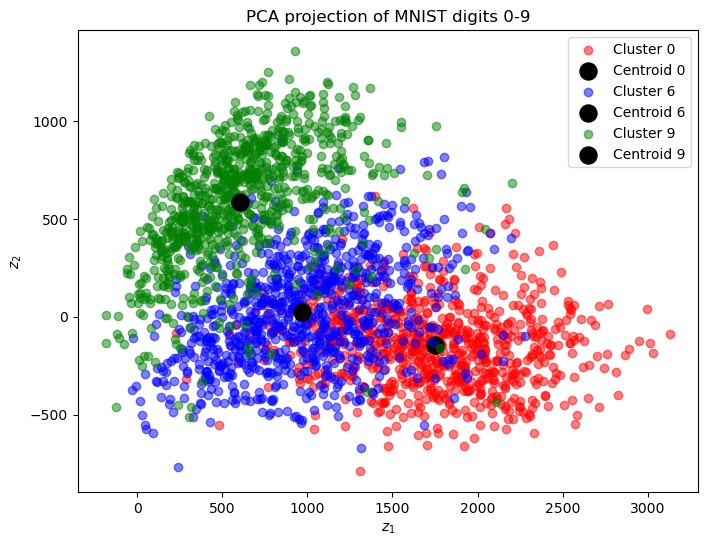

In [24]:
# same approach as before
train_centroid = centroids
clusters_test, centroids_test = cluster_centroid(Z_test, Y_test)

distance_test = distances(clusters_test, train_centroid)


print(distance_test)

data_visualization(clusters_test, centroids_test, Y_test)

As we can see from the plot, although it is less dense with points, it still demonstrates that the PCA algorithm worked correctly on the test set, as the classification was successfully performed.
Then, we can conclude that the algorithm worked well, as the distances are very similar to those computed for the training set.


8. Define a classification algorithm in this way: given a new observation $x$, compute the distance between $x$ and each cluster centroid computed on the training set. Assign $x$ to the class corresponding to the closest centroid. Compute the misclassification rate of this algorithm on the test set

In [25]:
def newClassifier(x, train_centroids):
    # lists to save the distances and relative labels
    distances = []
    labels = []
    
    for label, points in train_centroids.items():
        # compute distance
        d = np.linalg.norm(x - points)
        
        # update both lists
        distances.append(d)
        labels.append(label)  
    
    # find the index of the lowest distance 
    min_index = distances.index(min(distances))
    
    # use that index to return the lowest distance and the relative label
    return labels[min_index]


i = 40
x = Z_test[:, i]

label = newClassifier(x, train_centroid)
print(f"Expected label is {Y_test[i]}, and classification label is {label}")

Expected label is 6, and classification label is 6


In [26]:
def compute_misclassification_rate(Z_test,Y_test, centroids):
    # Using this new classifier, let's compute the missclassification error
    misclassification_rate = 0
    for i in range(Z_test.shape[1]):
        # for each new observation in the test set
        x = Z_test[:, i]  
        # compute prediction
        pred_label = newClassifier(x, centroids)
        
        # check wether the prediction is correct or not
        if pred_label != Y_test[i]:
            misclassification_rate += 1
    return (misclassification_rate / Z_test.shape[1]) * 100

misclassification_rate = compute_misclassification_rate(Z_test,Y_test, centroids)
print(f"Misclassification rate: {misclassification_rate:.2f}%")

Misclassification rate: 17.34%



9. Repeat this experiment for different values of $k$ and different digits. What do you observe?


In [27]:
def experiment(n1, n2, n3, k):
    # filtered matrix for the new values
    X_filtered, Y_filtered = filtering_out(X, Y, n1, n2, n3)

    # computing the training and test set
    (X_train, Y_train), (X_test, Y_test) = sampling(X_filtered, Y_filtered)

    # projection of the train and test set on a lower-dimensional space 
    # and save it in Z_train and Z_test
    Z_train = PCA_algorithm(X, X_train, k)
    Z_test = PCA_algorithm(X, X_test, k)

    # compute clusters and centroids
    clusters, centroids = cluster_centroid(Z_train, Y_train)

    # compute missclassification rate
    misclassification_rate = compute_misclassification_rate(Z_test, Y_test, centroids)
    return misclassification_rate


numbers = [(1,5,9), (0,6,8), (4,2,3)]
k_val = [1, 3, 10, 20]
for n1, n2, n3 in numbers: 
    for k in k_val:
        misclassification_rate = experiment(n1, n2, n3, k)
        print(f"The missclassification error for the numbers {n1, n2, n3}, with dimension {k}, is {misclassification_rate:.2f}%")

The missclassification error for the numbers (1, 5, 9), with dimension 1, is 29.95%
The missclassification error for the numbers (1, 5, 9), with dimension 3, is 13.73%
The missclassification error for the numbers (1, 5, 9), with dimension 10, is 9.87%
The missclassification error for the numbers (1, 5, 9), with dimension 20, is 6.91%
The missclassification error for the numbers (0, 6, 8), with dimension 1, is 36.20%
The missclassification error for the numbers (0, 6, 8), with dimension 3, is 32.83%
The missclassification error for the numbers (0, 6, 8), with dimension 10, is 7.13%
The missclassification error for the numbers (0, 6, 8), with dimension 20, is 5.72%
The missclassification error for the numbers (4, 2, 3), with dimension 1, is 61.27%
The missclassification error for the numbers (4, 2, 3), with dimension 3, is 18.93%
The missclassification error for the numbers (4, 2, 3), with dimension 10, is 8.33%
The missclassification error for the numbers (4, 2, 3), with dimension 20, i

Of course, the more dimensions (k) we use, the better the missclassification rate will be, because the approssimation will be lower and lower.

10. Compare this classification algorithm with the one defined in the previous exercise. Which performs better?

When comparing this clustering algorithm to the one defined in the previous exercise, which uses SVD and projection, I observed that the former performs almost always quite better.

Missclassification rate on numbers $1,5,9$ is:
- $13.72\%$ for this clustering algorithm
- $32.79\%$ for the SVD and projection algorithm